In [1]:
import numpy as np
import scipy
import scipy.optimize
import matplotlib.pyplot as plt

This code is modified from the notebook provided to the class, I did not write most of this code. I wrote a modified k-means algorithm and slightly modified the plotting to fit what I wanted. Otherwise, the code is Adam's.

In [49]:
def generate_data(n, sigma = 0.01):
    # This function generates random data in three clusters
    # They always have the same centers, but gaussian variation in each dimension
    true_centers = np.array([[0.0, 0.5], [0.2, -0.2], [-0.2, -0.2]])
    true_clusters = np.random.randint(3, size = n)
    x = np.zeros([n,2])
    for i in range(n):
        x[i] = true_centers[true_clusters[i]]
    x = x + np.random.normal(loc = 0.0, scale = sigma, size = [n,2])

    # Project to the L1 ball of radius 1. 
    for i in range(n): 
        l1norm = np.sum(np.abs(x[i]))
        if l1norm > 1:
            x[i] = x[i]/l1norm
    return x, true_centers, true_clusters

def lloydsalg(x, k, T, initial_centers=None):
    # This algorithm runs Lloyd's algorithm (also called k-means)
    # If no initial centers provided, generate random ones
    if initial_centers == None:
        initial_centers = np.random.normal(loc=0.0, scale=0.3, size = [k, 2])

    # Create lists to document algorithm's history
    centers_list = [initial_centers]
    closest_list = []
    
    current_centers = initial_centers.copy()
    
    n = len(x)
    
    for t in range(T):
        # assign each point to its nearest cluster 
        closest = np.zeros(n, dtype=np.int32) #The type forces indices to be integers
        for i in range(n):
            distances = np.zeros(k)
            for j in range(k):
                distances[j] = np.linalg.norm(x[i,:] - current_centers[j,:])
            closest[i] = np.argmin(distances)
        
        closest_list.append(closest) 
        
        # Now compute the number of points in each group, and ...
        sums = np.zeros([k,2])
        counts = np.zeros(k, dtype=np.int32) #The type forces counts to be integers
        for i in range(n):
            this_index = closest[i]
            counts[this_index] += 1 # counter number of points
            sums[this_index,:] += x[i,:] # add the points for this group
        # ... compute new cluster centers
        current_centers = np.zeros([k,2])
        for j in range(k):
            if counts[j]==0:
                print("Whoa! Group of size zero at (t,j)= ", t, j)
                # Re-initialize this center at random. 
                current_centers[j,:] = np.random.normal(loc=0.0, scale=0.1, size = 2)
            else:
                current_centers[j,:] = sums[j,:] / float(counts[j])
        
        centers_list.append(current_centers)
    
    closest_list.append(np.zeros(n, dtype=np.int8))
    return centers_list, closest_list

def noisy_k_means(x, k, T, epsilon, initial_centers=None):
    """eps-DP kmeans, as provided in class. Based on code from Adam Smith, my changes set off by comments."""
    ##################################################################################
    epsilon_prime = epsilon / (2 * T)  # changes are within these blocks
    ##################################################################################
    
    if initial_centers == None:
        initial_centers = np.random.normal(loc=0.0, scale=0.3, size = [k, 2])

    # Create lists to document algorithm's history
    centers_list = [initial_centers]
    closest_list = []
    
    current_centers = initial_centers.copy()
    
    n = len(x)
    
    for t in range(T):
        # assign each point to its nearest cluster 
        closest = np.zeros(n, dtype=np.int32) #The type forces indices to be integers
        for i in range(n):
            distances = np.zeros(k)
            for j in range(k):
                distances[j] = np.linalg.norm(x[i,:] - current_centers[j,:])
            closest[i] = np.argmin(distances)
        
        closest_list.append(closest) 
        
        # Now compute the number of points in each group, and ...
        sums = np.zeros([k,2])
        counts = np.zeros(k, dtype=np.int32) #The type forces counts to be integers
        for i in range(n):
            this_index = closest[i]
            counts[this_index] += 1 # counter number of points
            sums[this_index,:] += x[i,:] # add the points for this group
        # ... compute new cluster centers
        current_centers = np.zeros([k,2])
        
        ##################################################################################
        noisy_counts = counts + np.random.laplace(loc=0, scale=1/epsilon_prime, size=counts.shape)
        for j in range(k):
            if noisy_counts[j] <= 5:
                # Re-initialize this center at random. 
                current_centers[j,:] = np.random.normal(loc=0.0, scale=0.1, size = 2)
            else:
                noise = np.random.laplace(0, 2/epsilon_prime, current_centers[j,:].shape)
                current_centers[j,:] = (sums[j,:] + noise) / float(noisy_counts[j])
        ##################################################################################
        
        centers_list.append(current_centers)
    
    closest_list.append(np.zeros(n, dtype=np.int8))
    return centers_list, closest_list

In [50]:
#Let's generate some data!
np.random.seed(591)
x, true_centers, true_clusters = generate_data(2000, sigma = 0.05)

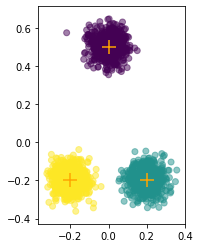

In [51]:
# Plot the data. Colors represent the true cluster of origin
# The clusters overlap significantly for sigma bigger than about 0.1
plt.scatter(x[:,0], x[:,1], c = true_clusters, alpha=0.5)
plt.scatter(true_centers[:,0], true_centers[:,1], marker='+', c='orange', s =200)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

In [100]:
# Now run noisy k-means

np.random.seed(591)

# centers_list, closest_list = lloydsalg(x, k=3, T=10)
centers_list, closest_list = noisy_k_means(x, k=3, T=10, epsilon=0.5)

T: 0


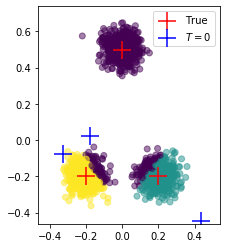

T: 1


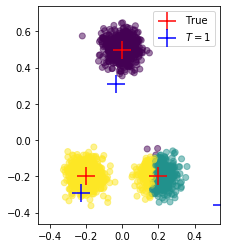

T: 2


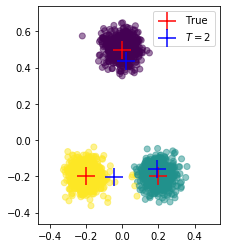

T: 3


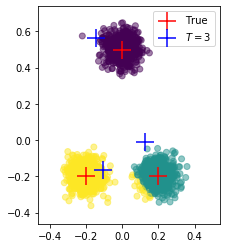

T: 4


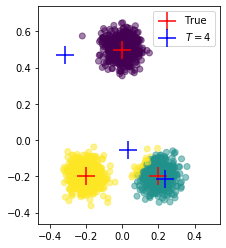

T: 5


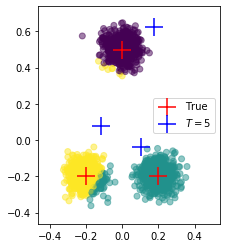

T: 6


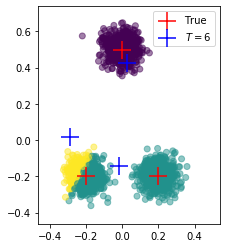

T: 7


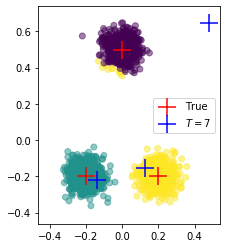

T: 8


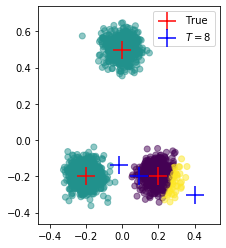

T: 9


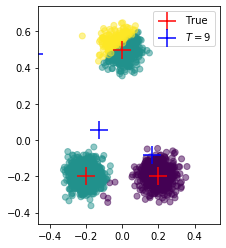

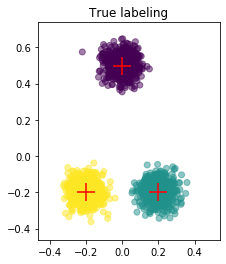

In [101]:
# Plot the centers and clusters at each stage. 

# first, find sensible axis limits
hi = np.max(x, axis=(0,1))
lo = np.min(x, axis=(0,1))
xmin = lo-0.1
ymin = lo-0.1
side = 1.2

for t in range(len(centers_list)-1): 
    centers = centers_list[t]
    closest = closest_list[t]
    plt.scatter(x[:,0], x[:,1], c = closest, alpha=0.5)
    plt.scatter(true_centers[:,0], true_centers[:,1], marker = '+', c = 'red', s =300, label='True')
    plt.scatter(centers[:,0], centers[:,1], marker='+', c='blue', s =300, label='$T=$'+str(t))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis([xmin, xmin+side-0.2, ymin, ymin+side])
    plt.legend()
#     plt.savefig('figures/eps_half_T_'+str(t)+'.png', bbox_inches='tight')
    plt.show()
# The last plot shows the final cluster centers with colors representing original clusters. 
final_centers = centers_list[-1]
plt.scatter(x[:,0], x[:,1], c = true_clusters, alpha=0.5)
plt.scatter(true_centers[:,0], true_centers[:,1], marker = '+', c = 'red', s =300)
# plt.scatter(final_centers[:,0], final_centers[:,1], marker='+', c='blue', s =300)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([xmin, xmin+side-0.2, ymin, ymin+side])
plt.title('True labeling')
# plt.savefig('figures/true_labeling.png', bbox_inches='tight')
plt.show()

# 